In [2]:
# %%
# =============================================================================
# 1. IMPORTS AND CONFIGURATION
# =============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from timm import create_model
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import seaborn as sns
import json

warnings.filterwarnings('ignore')

# Configuration pointing to the timm model ID
config = {
    'base_dir': r'dataset/',
    'model_name': 'cait_s24_224',  # CHANGED: Removed the '.in1k' suffix
    'batch_size': 16,
    'img_size': 224,
    'weight_decay': 0.01,
    'epochs': 80,
    'num_workers': 0,
    'pin_memory': True,
    'patience': 12,
    'drop_rate': 0.4,
    'head_lr': 1e-3,
    'head_epochs': 10,
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.4
}

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# =============================================================================
# 2. DATASET CLASS (No Changes Needed)
# =============================================================================
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        self.classes = sorted([d for d in os.listdir(self.data_dir)
                               if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Found {len(self.image_paths)} images in {split} set")
        print(f"Classes: {self.classes}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# =============================================================================
# 3. TRANSFORMS AND DATALOADERS
# =============================================================================
def get_enhanced_transforms(img_size):
    # CHANGED: Use standard ImageNet normalization for timm models
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    print(f"Using standard ImageNet normalization: mean={mean}, std={std}")

    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    return train_transform, val_transform

train_transform, val_transform = get_enhanced_transforms(config['img_size'])
train_dataset = MelSpectrogramDataset(config['base_dir'], 'train', train_transform)
val_dataset = MelSpectrogramDataset(config['base_dir'], 'val', val_transform)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=config['num_workers'], pin_memory=config['pin_memory'])
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=config['num_workers'], pin_memory=config['pin_memory'])

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# =============================================================================
# 4. AUGMENTATION (No Changes Needed)
# =============================================================================
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param, time_mask_param, num_freq_masks=1, num_time_masks=1):
        super(SpecAugment, self).__init__()
        self.F, self.T = freq_mask_param, time_mask_param
        self.num_freq_masks, self.num_time_masks = num_freq_masks, num_time_masks

    def forward(self, x):
        sh = x.shape
        for _ in range(self.num_freq_masks):
            f = np.random.uniform(0.0, self.F)
            f0 = np.random.randint(0, sh[2] - int(f)) if sh[2] > int(f) else 0
            x[:, :, f0:f0+int(f), :] = 0
        for _ in range(self.num_time_masks):
            t = np.random.uniform(0.0, self.T)
            t0 = np.random.randint(0, sh[3] - int(t)) if sh[3] > int(t) else 0
            x[:, :, :, t0:t0+int(t)] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=25, time_mask_param=40).to(device)

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =============================================================================
# 5. MODEL DEFINITION (Using timm)
# =============================================================================
# CHANGED: Replaced TransformersClassifier with TimmClassifier
class TimmClassifier(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.3):
        super().__init__()
        # Load the backbone using create_model from the timm library
        self.backbone = create_model(
            model_name,
            pretrained=True,
            num_classes=0  # Set to 0 to remove the final classifier
        )
        
        # Get the feature dimension from the model
        feature_dim = self.backbone.num_features
        print(f"Feature dimension from timm model: {feature_dim}")

        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # The timm model directly outputs features after pooling
        features = self.backbone(x)
        return self.classifier(features)

model = TimmClassifier(
    config['model_name'], num_classes, config['drop_rate']
).to(device)
print("✅ Model created successfully using the timm library!")

# =============================================================================
# 6. TRAINING & VALIDATION LOOPS (No Changes Needed)
# =============================================================================
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, all_preds, all_labels = 0.0, [], []
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        images = spec_augment(images)
        images, targets_a, targets_b, lam = mixup_data(images, labels, config['mixup_alpha'])
        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), accuracy_score(all_labels, all_preds)

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, all_preds, all_labels = 0.0, [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), accuracy_score(all_labels, all_preds), all_preds, all_labels

Using standard ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
Found 19880 images in train set
Classes: ['Alapadmam(1)', 'Anjali(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Berunda(1)', 'Bramaram(1)', 'Chakra(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Garuda(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Kapotham(1)', 'Karkatta(1)', 'Kartariswastika(1)', 'Katakamukha_1', 'Katakamukha_2', 'Katakamukha_3', 'Katakavardhana(1)', 'Katrimukha(1)', 'Khatva(1)', 'Kilaka(1)', 'Kurma(1)', 'Matsya(1)', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Nagabandha(1)', 'Padmakosha(1)', 'Pasha(1)', 'Pathaka(1)', 'Pushpaputa(1)', 'Sakata(1)', 'Samputa(1)', 'Sarpasirsha(1)', 'Shanka(1)', 'Shivalinga(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Swastikam(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)', 'Varaha(1)']
Found 4240 images in val set
Classes: ['Alapadmam(1)', 'Anjali(1)', 'Aralam(1)', 'Ardhac

🧪 EVALUATING FINE-TUNED MODEL ON TEST DATA
Using standard ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
Found 4311 images in test set
Classes: ['Alapadmam(1)', 'Anjali(1)', 'Aralam(1)', 'Ardhachandran(1)', 'Ardhapathaka(1)', 'Berunda(1)', 'Bramaram(1)', 'Chakra(1)', 'Chandrakala(1)', 'Chaturam(1)', 'Garuda(1)', 'Hamsapaksha(1)', 'Hamsasyam(1)', 'Kangulam(1)', 'Kapith(1)', 'Kapotham(1)', 'Karkatta(1)', 'Kartariswastika(1)', 'Katakamukha_1', 'Katakamukha_2', 'Katakamukha_3', 'Katakavardhana(1)', 'Katrimukha(1)', 'Khatva(1)', 'Kilaka(1)', 'Kurma(1)', 'Matsya(1)', 'Mayura(1)', 'Mrigasirsha(1)', 'Mukulam(1)', 'Mushti(1)', 'Nagabandha(1)', 'Padmakosha(1)', 'Pasha(1)', 'Pathaka(1)', 'Pushpaputa(1)', 'Sakata(1)', 'Samputa(1)', 'Sarpasirsha(1)', 'Shanka(1)', 'Shivalinga(1)', 'Shukatundam(1)', 'Sikharam(1)', 'Simhamukham(1)', 'Suchi(1)', 'Swastikam(1)', 'Tamarachudam(1)', 'Tripathaka(1)', 'Trishulam(1)', 'Varaha(1)']
📊 Test dataset: 4311 samples
🎯 Number of classe

Processing test batches: 100%|██████████| 270/270 [01:45<00:00,  2.56it/s]


✅ Test Accuracy: 0.9042 (90.42%)


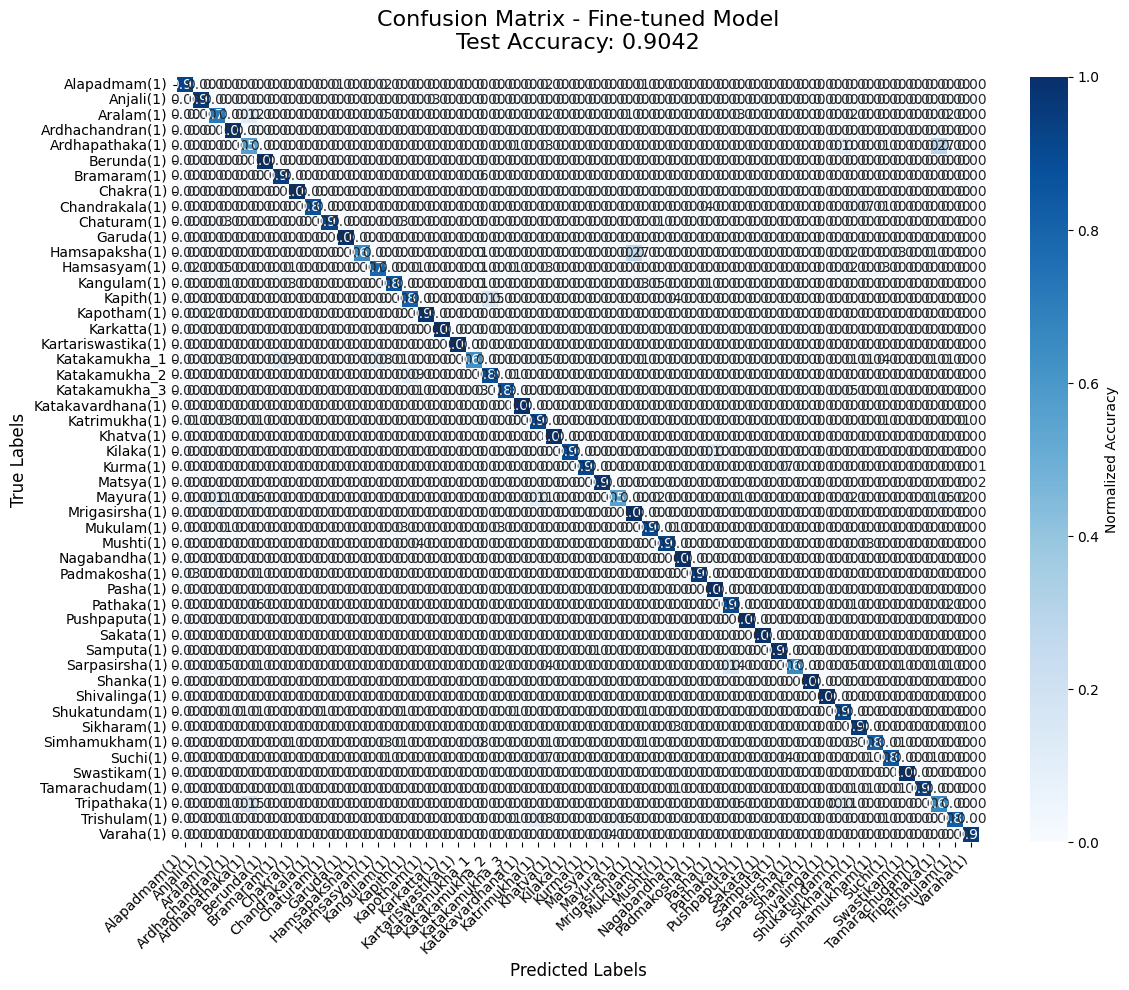


📊 DETAILED CLASSIFICATION REPORT
                    precision    recall  f1-score   support

      Alapadmam(1)     0.9383    0.9268    0.9325        82
         Anjali(1)     0.9775    0.9667    0.9721        90
         Aralam(1)     0.6979    0.7204    0.7090        93
  Ardhachandran(1)     0.9859    1.0000    0.9929        70
   Ardhapathaka(1)     0.5682    0.5682    0.5682        88
        Berunda(1)     1.0000    1.0000    1.0000        87
       Bramaram(1)     0.8442    0.9420    0.8904        69
         Chakra(1)     1.0000    1.0000    1.0000        92
    Chandrakala(1)     0.9841    0.8732    0.9254        71
       Chaturam(1)     0.9851    0.9296    0.9565        71
         Garuda(1)     1.0000    1.0000    1.0000        96
    Hamsapaksha(1)     1.0000    0.6512    0.7887        86
      Hamsasyam(1)     0.8095    0.7907    0.8000        86
       Kangulam(1)     0.8961    0.8625    0.8790        80
         Kapith(1)     0.8519    0.8118    0.8313        85
     

In [4]:
# %%
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader

def plot_confusion_matrix(model, test_loader, device, class_names, save_path='confusion_matrix_finetuned.png'):
    model.eval()
    all_predictions = []
    all_targets = []
    
    print("🔍 Generating predictions on test data...")
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Processing test batches"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    test_accuracy = accuracy_score(all_targets, all_predictions)
    print(f"✅ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    
    cm = confusion_matrix(all_targets, all_predictions)
    
    plt.figure(figsize=(12, 10))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Normalized Accuracy'})
    
    plt.title(f'Confusion Matrix - Fine-tuned Model\nTest Accuracy: {test_accuracy:.4f}', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm, all_predictions, all_targets, test_accuracy

def print_detailed_classification_report(all_targets, all_predictions, class_names):
    print("\n" + "="*60)
    print("📊 DETAILED CLASSIFICATION REPORT")
    print("="*60)
    
    report = classification_report(all_targets, all_predictions, 
                                  target_names=class_names, digits=4)
    print(report)

def analyze_confusion_matrix(cm, class_names):
    print("\n" + "="*60)
    print("🔍 CONFUSION MATRIX ANALYSIS")
    print("="*60)
    
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i, j]))
    
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\nTop Misclassifications:")
    for true_label, pred_label, count in confusion_pairs[:10]:
        print(f"  {true_label} → {pred_label}: {count} samples")
    
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i].sum()
        accuracy = correct / total if total > 0 else 0
        print(f"  {class_name}: {accuracy:.4f} ({correct}/{total})")

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    FINETUNED_MODEL_PATH = 'best_head_model.pth'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("🧪 EVALUATING FINE-TUNED MODEL ON TEST DATA")
    print("="*50)
    
    _, test_transform = get_enhanced_transforms(config['img_size'])
    test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', test_transform)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False,
        num_workers=config.get('num_workers', 2),
        pin_memory=config.get('pin_memory', True)
    )
    
    class_names = test_dataset.classes
    num_classes = len(class_names)
    
    print(f"📊 Test dataset: {len(test_dataset)} samples")
    print(f"🎯 Number of classes: {num_classes}")
    print(f"📝 Classes: {class_names}")
    
    # CHANGED: Use TimmClassifier for final evaluation
    model = TimmClassifier(
        config['model_name'], num_classes, config['drop_rate']
    ).to(device)
    
    model.load_state_dict(torch.load(FINETUNED_MODEL_PATH, map_location=device))
    print(f"✅ Loaded fine-tuned model from: {FINETUNED_MODEL_PATH}")
    
    cm, predictions, targets, test_accuracy = plot_confusion_matrix(
        model, test_loader, device, class_names,
        save_path='confusion_matrix_finetuned_final.png'
    )
    
    print_detailed_classification_report(targets, predictions, class_names)
    analyze_confusion_matrix(cm, class_names)
    
    print(f"\n✅ Evaluation complete!")
    print(f"💾 Confusion matrix saved as: confusion_matrix_finetuned_final.png")